![](img/330-banner.png)

# Lecture 20: Ethics

UBC 2020-21

Instructor: Varada Kolhatkar

## Imports

In [1]:
import os
import sys

sys.path.append("code/.")

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

from IPython.display import Image

<br><br>

## Lecture plan 

- Guest lecture by [Joel Ostblom](https://joelostblom.com/) (~40 mins to 1 hour)
- ML fairness activity (~15 mins)

## ML fairness activity

AI/ML systems can give the illusion of objectivity as they are derived from seemingly unbiased data & algorithm. However, human are inherently biased and AI/ML systems, if not carefully evaluated, can even further amplify the existing inequities and systemic bias in our society.  

How do we make sure our AI/ML systems are *fair*? Which metrics can we use to quatify 'fairness' in AI/ML systems?

Let's examine this on [the adult census data set](https://www.kaggle.com/uciml/adult-census-income). 

In [80]:
census_df = pd.read_csv("data/adult.csv")
census_df.shape

(32561, 15)

In [81]:
train_df, test_df = train_test_split(census_df, test_size=0.4, random_state=42)

In [82]:
train_df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
25823,36,Private,245521,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,35,Mexico,<=50K
10274,26,Private,134287,Assoc-voc,11,Never-married,Sales,Own-child,White,Female,0,0,35,United-States,<=50K
27652,25,Local-gov,109526,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,38,United-States,<=50K
13941,23,Private,131275,HS-grad,9,Never-married,Craft-repair,Own-child,Amer-Indian-Eskimo,Male,0,0,40,United-States,<=50K
31384,27,Private,193122,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,25,Private,410240,HS-grad,9,Never-married,Craft-repair,Own-child,White,Male,0,0,40,United-States,<=50K
5390,51,Private,146767,Assoc-voc,11,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,>50K
860,55,Federal-gov,238192,HS-grad,9,Married-civ-spouse,Tech-support,Husband,White,Male,0,1887,40,United-States,>50K
15795,41,Private,154076,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,50,United-States,>50K


In [83]:
train_df_nan = train_df.replace("?", np.nan)
test_df_nan = test_df.replace("?", np.nan)
train_df_nan.shape

(19536, 15)

In [84]:
# Let's identify numeric and categorical features

numeric_features = [
    "age",
    "fnlwgt",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
]

categorical_features = [
    "workclass",
    "marital.status",
    "occupation",
    "relationship",
    # "race",
    "native.country",
]

ordinal_features = ["education"]
binary_features = [
    "sex"
]  # Not binary in general but in this particular dataset it seems to have only two possible values
drop_features = ["education.num"]
target = "income"

In [85]:
train_df["education"].unique()

array(['7th-8th', 'Assoc-voc', 'HS-grad', 'Bachelors', 'Some-college',
       '10th', '11th', 'Prof-school', '12th', '5th-6th', 'Masters',
       'Assoc-acdm', '9th', 'Doctorate', '1st-4th', 'Preschool'],
      dtype=object)

In [86]:
education_levels = [
    "Preschool",
    "1st-4th",
    "5th-6th",
    "7th-8th",
    "9th",
    "10th",
    "11th",
    "12th",
    "HS-grad",
    "Prof-school",
    "Assoc-voc",
    "Assoc-acdm",
    "Some-college",
    "Bachelors",
    "Masters",
    "Doctorate",
]

In [87]:
assert set(education_levels) == set(train_df["education"].unique())

In [88]:
X_train = train_df_nan.drop(columns=[target])
y_train = train_df_nan[target]

X_test = test_df_nan.drop(columns=[target])
y_test = test_df_nan[target]

In [89]:
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

numeric_transformer = make_pipeline(StandardScaler())

ordinal_transformer = OrdinalEncoder(categories=[education_levels], dtype=int)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

binary_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
    OneHotEncoder(drop="if_binary", dtype=int),
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (ordinal_transformer, ordinal_features),
    (binary_transformer, binary_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

In [90]:
y_train.value_counts()

<=50K    14841
>50K      4695
Name: income, dtype: int64

In [91]:
pipe_lr = make_pipeline(
    preprocessor, LogisticRegression(class_weight="balanced", max_iter=1000)
)

In [92]:
pipe_lr.fit(X_train, y_train);

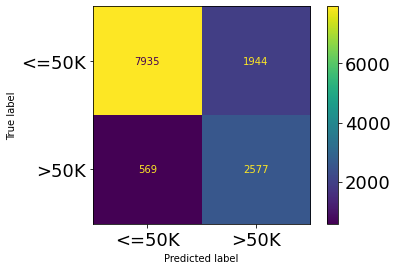

In [93]:
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_test, y_test);

Let's examine confusion matrix separately for the two genders we have in the data. 

In [94]:
X_train_enc = preprocessor.fit_transform(X_train)
preprocessor.named_transformers_["pipeline-2"]["onehotencoder"].get_feature_names_out()

array(['x0_Male'], dtype=object)

In [95]:
X_test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
14160,29,Private,280618,Some-college,10,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,United-States
27048,19,Private,439779,Some-college,10,Never-married,Sales,Own-child,White,Male,0,0,15,United-States
28868,28,Private,204734,Some-college,10,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,40,United-States
5667,35,Private,107991,11th,7,Never-married,Sales,Not-in-family,White,Male,0,0,45,United-States
7827,20,Private,54152,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,30,NaN


In [96]:
X_female = X_test.query("sex=='Female'")
X_male = X_test.query("sex=='Male'")

y_female = y_test[X_female.index]
y_male = y_test[X_male.index]
female_preds = pipe_lr.predict(X_female)
male_preds = pipe_lr.predict(X_male)

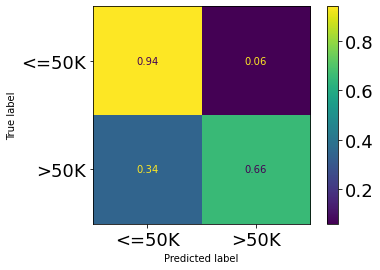

In [97]:
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_female, y_female, normalize="true");

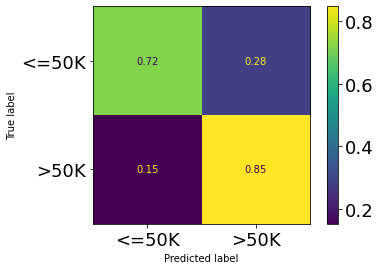

In [98]:
ConfusionMatrixDisplay.from_estimator(pipe_lr, X_male, y_male, normalize="true");

What's the accuracy of this model? 

In [99]:
data = {"male": [], "female": []}
f_TN, f_FP, f_FN, f_TP = confusion_matrix(y_female, female_preds).ravel()
m_TN, m_FP, m_FN, m_TP = confusion_matrix(y_male, male_preds).ravel()

In [100]:
accuracy_male = accuracy_score(y_male, male_preds)
accuracy_female = accuracy_score(y_female, female_preds)
data["male"].append(accuracy_male)
data["female"].append(accuracy_female)

print("Accuracy male: {:.3f}".format(accuracy_male))
print("Accuracy female: {:.3f}".format(accuracy_female))

Accuracy male: 0.756
Accuracy female: 0.910


In [101]:
y_female.value_counts(normalize=True)

<=50K    0.892675
>50K     0.107325
Name: income, dtype: float64

In [102]:
y_male.value_counts(normalize=True)

<=50K    0.691999
>50K     0.308001
Name: income, dtype: float64

There is more class imbalance for female! 

Let's assume that a company is using this classifier for loan approval with a simple rule that if the income is >=50K, approve the loan else reject the loan. 

**Statistical parity** suggests that the proportion of each segment of a protected class (e.g. sex) should receive the positive outcome at equal rates. For example, the number of loans approved for female should be equal to male.

Calculate the precision for male and female. Based on your results, do you think this income classifier is fair?

In [103]:
precision_male = precision_score(y_male, male_preds, pos_label=">50K")
precision_female = precision_score(y_female, female_preds, pos_label=">50K")
data["male"].append(precision_male)
data["female"].append(precision_female)

print("Precision male: {:.3f}".format(precision_male))
print("Precision female: {:.3f}".format(precision_female))

Precision male: 0.570
Precision female: 0.568


**Equal opportunity** suggests that each group should get the positive outcome at equal rates, assuming that people in this group qualify for it. For example, if a man and a woman have both a certain level of income, we want them to have the same chance of getting the loan. In other words, the true positive rate (TPR or recall) of both groups should be equal.

In [104]:
recall_male = recall_score(y_male, male_preds, pos_label=">50K")
recall_female = recall_score(y_female, female_preds, pos_label=">50K")

data["male"].append(recall_male)
data["female"].append(recall_female)

print("Recall male: {:.3f}".format(recall_male))
print("Recall female: {:.3f}".format(recall_female))

Recall male: 0.847
Recall female: 0.657


There is usually a tradeoff between rationality (adopting effective means to achieve your desired outcome) and bias. The desired outcome of banks, for example, is to maximize their profit. So in many circumstances, they not only care about approving as many qualified applications as possible (true positive), but also to avoid approving unqualified applications (false postive) because default loan could have detrimental effects for them. 

Let's examine false positive rate (FPR) of both groups.

In [105]:
fpr_male = m_FP / (m_FP + m_TN)
fpr_female = f_FP / (f_FP + f_TN)

data["male"].append(fpr_male)
data["female"].append(fpr_female)

print("FPR male: {:.3f}".format(fpr_male))
print("FPR female: {:.3f}".format(fpr_female))

FPR male: 0.284
FPR female: 0.060


In [106]:
pd.DataFrame(data, index=["accuracy", "precision", "recall", "FPR"])

,male,female
accuracy,0.756285,0.909597
precision,0.570246,0.568224
recall,0.847186,0.656587
FPR,0.284174,0.059984


- Discuss these results with your neighbours. 
- Does the effect still exist if the sex feature is removed from the model (but you still have it available separately to do the two confusion matrices)? 